<a href="https://colab.research.google.com/github/Abi2695/Proyecto_investigacion/blob/main/Random_Forest_AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importar librerías**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Cargar el archivo y poner ruta de base de datos**

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
ruta = "/content/drive/MyDrive/Tesis Maestria UDLA/Base de datos/Produccion linea 6 y 7 mayo a nov 2025.xlsx"

df = pd.read_excel(ruta)

# 1) Normalizar nombres de columnas
df.columns = (
    df.columns.astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)

print("Dimensión (filas, columnas):", df.shape)
print("\nColumnas:")
print(list(df.columns))

print("\nTipos de datos:")
print(df.dtypes)

print("\nPrimeras 5 filas:")
display(df.head())

Dimensión (filas, columnas): (1986, 14)

Columnas:
['FECHA', 'OF', 'LINEA', 'TURNO', 'CODIGO', 'PRODUCTO', 'INICIO_PROCESO', 'FIN_PROCESO', 'TIEMPO ALM/MER', 'DURACION (HORAS)', 'SUPERVISOR', 'UNIDADES PRODUCIDAS', 'PRODUCCION X HORA', 'PARO MAQUINA']

Tipos de datos:
FECHA                  datetime64[ns]
OF                              int64
LINEA                           int64
TURNO                           int64
CODIGO                         object
PRODUCTO                       object
INICIO_PROCESO                 object
FIN_PROCESO                    object
TIEMPO ALM/MER                 object
DURACION (HORAS)              float64
SUPERVISOR                     object
UNIDADES PRODUCIDAS           float64
PRODUCCION X HORA             float64
PARO MAQUINA                    int64
dtype: object

Primeras 5 filas:


,FECHA,OF,LINEA,TURNO,CODIGO,PRODUCTO,INICIO_PROCESO,FIN_PROCESO,TIEMPO ALM/MER,DURACION (HORAS),SUPERVISOR,UNIDADES PRODUCIDAS,PRODUCCION X HORA,PARO MAQUINA
0,2025-05-01,1204,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,1900-01-01 00:00:00,1900-01-01 00:05:00,NaN,0.083333,ADRIAN LOPEZ,287.909457,3454.913481,0
1,2025-05-01,1204,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,1900-01-01 00:05:00,1900-01-01 00:18:00,NaN,0.216667,ADRIAN LOPEZ,0.000000,NaN,1
2,2025-05-01,1204,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,1900-01-01 00:18:00,1900-01-01 02:28:00,00:30:00,1.666667,ADRIAN LOPEZ,5758.189135,3454.913481,0
3,2025-05-01,1204,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,1900-01-01 02:28:00,1900-01-01 02:50:00,NaN,0.366667,ADRIAN LOPEZ,0.000000,NaN,1
4,2025-05-01,1204,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,1900-01-01 02:50:00,1900-01-01 07:00:00,NaN,4.166667,ADRIAN LOPEZ,14395.472837,3454.913481,0


**Limpieza de datos**

In [15]:
df2 = df.copy()

# Asegurar FECHA
df2["FECHA"] = pd.to_datetime(df2["FECHA"], errors="coerce")

# Función robusta: convierte valores de hora a segundos desde medianoche
def time_to_seconds(col: pd.Series) -> pd.Series:
    s = col.copy()

    # 1) Si es numérico (Excel guarda horas como fracción del día)
    s_num = pd.to_numeric(s, errors="coerce")
    sec_from_num = s_num * 24 * 3600  # días -> segundos

    # 2) Si es texto o datetime: intentar parsear
    s_str = s.astype(str).replace(["nan", "NaT", "None"], np.nan)
    parsed_dt = pd.to_datetime(s_str, errors="coerce")  # puede leer "1900-01-01 00:05:00"
    sec_from_dt = (
        parsed_dt.dt.hour.fillna(0).astype(int) * 3600 +
        parsed_dt.dt.minute.fillna(0).astype(int) * 60 +
        parsed_dt.dt.second.fillna(0).astype(int)
    ).astype(float)
    sec_from_dt[parsed_dt.isna()] = np.nan

    # 3) Si viene como "HH:MM:SS" sin fecha: usar to_timedelta
    parsed_td = pd.to_timedelta(s_str, errors="coerce")
    sec_from_td = parsed_td.dt.total_seconds()

    # Combinar con prioridad: datetime > timedelta > num
    sec = sec_from_dt.copy()
    sec = sec.fillna(sec_from_td)
    sec = sec.fillna(sec_from_num)

    # valores fuera de rango se mandan a NaN (por seguridad)
    sec[(sec < 0) | (sec >= 24*3600)] = np.nan
    return sec

df2["inicio_sec"] = time_to_seconds(df2["INICIO_PROCESO"])
df2["fin_sec"]    = time_to_seconds(df2["FIN_PROCESO"])

print("Nulos inicio_sec:", df2["inicio_sec"].isna().sum(), "de", len(df2))
print("Nulos fin_sec:   ", df2["fin_sec"].isna().sum(), "de", len(df2))

# Construir timestamps reales (si falta inicio/fin, quedará NaT)
df2["inicio_dt"] = df2["FECHA"] + pd.to_timedelta(df2["inicio_sec"], unit="s")
df2["fin_dt"]    = df2["FECHA"] + pd.to_timedelta(df2["fin_sec"], unit="s")

# Si cruza medianoche
mask_cruza = (df2["fin_sec"].notna()) & (df2["inicio_sec"].notna()) & (df2["fin_sec"] < df2["inicio_sec"])
df2.loc[mask_cruza, "fin_dt"] = df2.loc[mask_cruza, "fin_dt"] + pd.Timedelta(days=1)

df2["duracion_calc_horas"] = (df2["fin_dt"] - df2["inicio_dt"]).dt.total_seconds() / 3600

print("\nCruce medianoche:", int(mask_cruza.sum()))
print("\nMuestra comparativa (10 filas) DURACION vs duracion_calc_horas:")
display(df2[["DURACION (HORAS)", "duracion_calc_horas", "INICIO_PROCESO", "FIN_PROCESO"]].sample(10, random_state=7))


Nulos inicio_sec: 0 de 1986
Nulos fin_sec:    0 de 1986

Cruce medianoche: 254

Muestra comparativa (10 filas) DURACION vs duracion_calc_horas:


,DURACION (HORAS),duracion_calc_horas,INICIO_PROCESO,FIN_PROCESO
1899,11.500000,12.000000,07:00:00,19:00:00
1808,0.516667,0.516667,02:17:00,02:48:00
140,4.500000,5.000000,19:00:00,1900-01-01 00:00:00
928,11.500000,12.000000,07:00:00,19:00:00
694,11.500000,12.000000,07:00:00,19:00:00
955,0.833333,0.833333,04:41:00,05:31:00
837,0.116667,0.116667,01:36:00,01:43:00
386,11.500000,12.000000,19:00:00,1900-01-01 07:00:00
735,0.083333,0.083333,12:35:00,12:40:00
1278,0.966667,0.966667,07:00:00,07:58:00


**Verificar balance de datos**

In [16]:
# Verificar desbalance de la clase ----
y = df2["PARO MAQUINA"].astype(int)

print("\nDistribución de PARO MAQUINA (conteo):")
display(y.value_counts().to_frame("conteo"))

print("\nDistribución de PARO MAQUINA (%):")
display((y.value_counts(normalize=True) * 100).round(2).to_frame("%"))

# (Opcional) tasa de paro por línea/turno para entender el problema
print("\nTasa de PARO por LINEA:")
display(df2.groupby("LINEA")["PARO MAQUINA"].mean().sort_values(ascending=False).to_frame("tasa_paro"))

print("\nTasa de PARO por TURNO:")
display(df2.groupby("TURNO")["PARO MAQUINA"].mean().sort_values(ascending=False).to_frame("tasa_paro"))



Distribución de PARO MAQUINA (conteo):


,conteo
PARO MAQUINA,
1,1193
0,793



Distribución de PARO MAQUINA (%):


,%
PARO MAQUINA,
1,60.07
0,39.93



Tasa de PARO por LINEA:


,tasa_paro
LINEA,
6,0.646196
7,0.545251



Tasa de PARO por TURNO:


,tasa_paro
TURNO,
1,0.703947
2,0.513035


# **Análisis descriptivo y exploratorio**

In [17]:
import datetime

df_eda = df2.copy()

# Asegurar target
df_eda["PARO MAQUINA"] = df_eda["PARO MAQUINA"].astype(int)

# Variables de tiempo útiles
df_eda["dia_semana"] = df_eda["FECHA"].dt.dayofweek
df_eda["mes"]        = df_eda["FECHA"].dt.month

df_eda["inicio_hora"] = (df_eda["inicio_sec"] // 3600).astype(int)
df_eda["inicio_min"]  = ((df_eda["inicio_sec"] % 3600) // 60).astype(int)

# TIEMPO ALM/MER a minutos (NaN->0)
# Convertir objetos datetime.time a pd.Timedelta explícitamente
df_eda["TIEMPO ALM/MER_td"] = df_eda["TIEMPO ALM/MER"].apply(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second) if pd.notna(x) and isinstance(x, datetime.time) else pd.to_timedelta(x, errors="coerce"))
df_eda["alm_mer_min"] = df_eda["TIEMPO ALM/MER_td"].dt.total_seconds().fillna(0) / 60

# Duración final
df_eda["duracion_horas_final"] = df_eda["duracion_calc_horas"]

# Revisión rápida
print("Filas:", len(df_eda))
print("Rango FECHA:", df_eda["FECHA"].min(), "->", df_eda["FECHA"].max())
print("Nulos duracion_horas_final:", df_eda["duracion_horas_final"].isna().sum())

Filas: 1986
Rango FECHA: 2025-05-01 00:00:00 -> 2025-11-29 00:00:00
Nulos duracion_horas_final: 0


**Analisis descriptivo**

In [18]:
# Columnas numéricas
num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()

# Resumen estadístico
desc = df_eda[num_cols].describe().T
desc["missing"] = df_eda[num_cols].isna().sum()
display(desc.sort_values("missing", ascending=False))


,count,mean,std,min,25%,50%,75%,max,missing
TIEMPO ALM/MER_td,460,0 days 00:30:51.391304347,0 days 00:16:10.273987723,0 days 00:00:00,0 days 00:30:00,0 days 00:30:00,0 days 00:30:00,0 days 04:31:00,1526
UNIDADES PRODUCIDAS,1976.0,13433.972166,20517.080926,0.0,0.0,0.0,23902.359019,86030.0,10
PRODUCCION X HORA,1981.0,1675.406225,2254.597493,0.0,0.0,0.0,3931.867925,9686.045694,5
OF,1986.0,1755.317221,257.380621,1204.0,1575.0,1771.0,1944.0,2327.0,0
TURNO,1986.0,1.540785,0.498459,1.0,1.0,2.0,2.0,2.0,0
DURACION (HORAS),1986.0,3.356814,4.235902,0.0,0.133333,0.566667,6.5,24.333333,0
PARO MAQUINA,1986.0,0.600705,0.489877,0.0,0.0,1.0,1.0,1.0,0
inicio_sec,1986.0,39237.099698,25881.135128,0.0,22200.0,36000.0,68400.0,86280.0,0
LINEA,1986.0,6.450655,0.497684,6.0,6.0,6.0,7.0,7.0,0
fin_sec,1986.0,40656.797583,25824.144511,0.0,25200.0,37200.0,68400.0,86340.0,0


**Análisis exploratorio**

PARO MAQUINA
1    1193
0     793
Name: count, dtype: int64
PARO MAQUINA
1    0.600705
0    0.399295
Name: proportion, dtype: float64


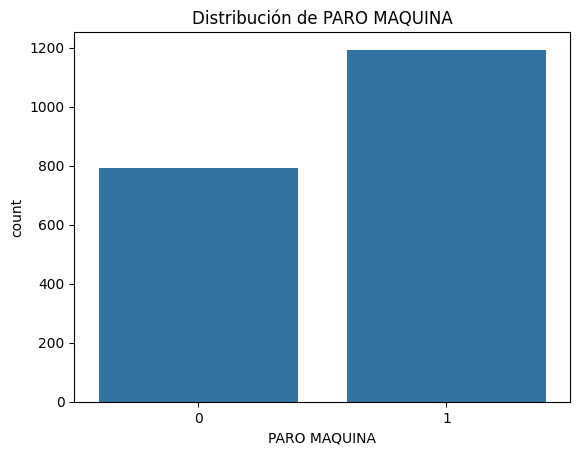

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

target = "PARO MAQUINA"

print(df_eda[target].value_counts())
print(df_eda[target].value_counts(normalize=True))

sns.countplot(x=target, data=df_eda)
plt.title("Distribución de PARO MAQUINA")
plt.show()

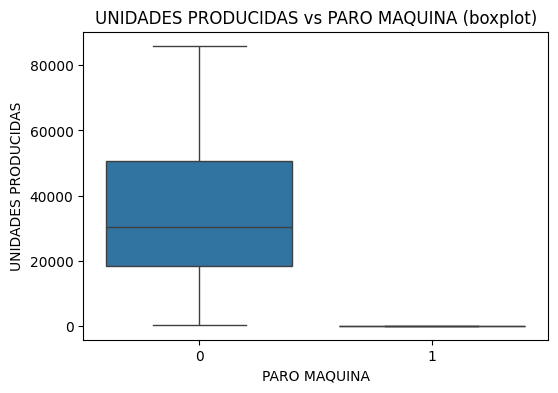

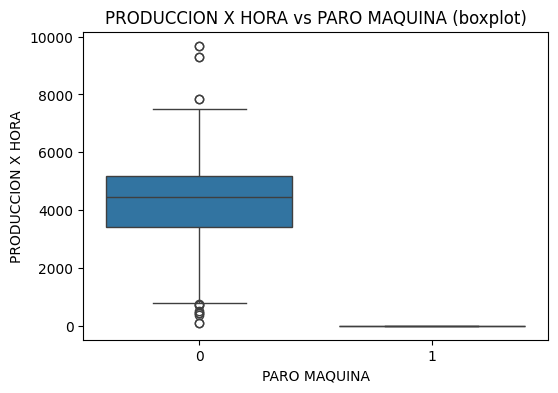

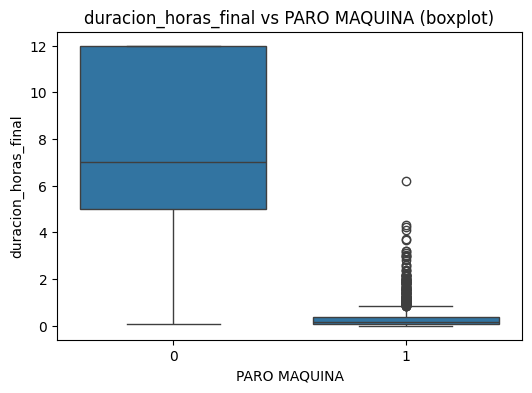

In [20]:
num_candidates = [c for c in ['UNIDADES PRODUCIDAS','PRODUCCION X HORA','duracion_horas_final'] if c in df_eda.columns]
for c in num_candidates:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target, y=c, data=df_eda)
    plt.title(f"{c} vs PARO MAQUINA (boxplot)")
    plt.show()

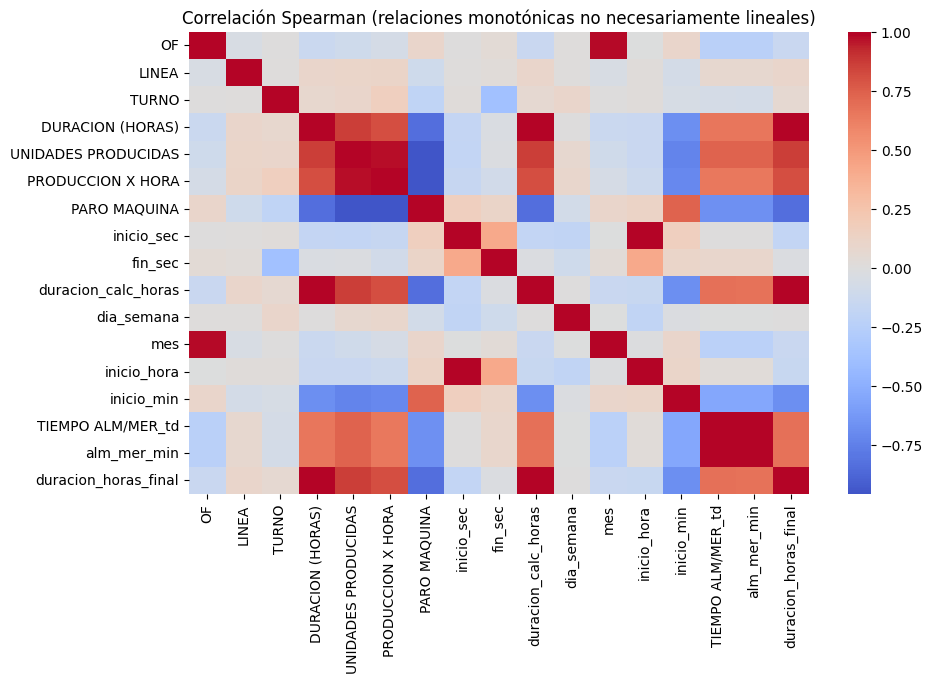

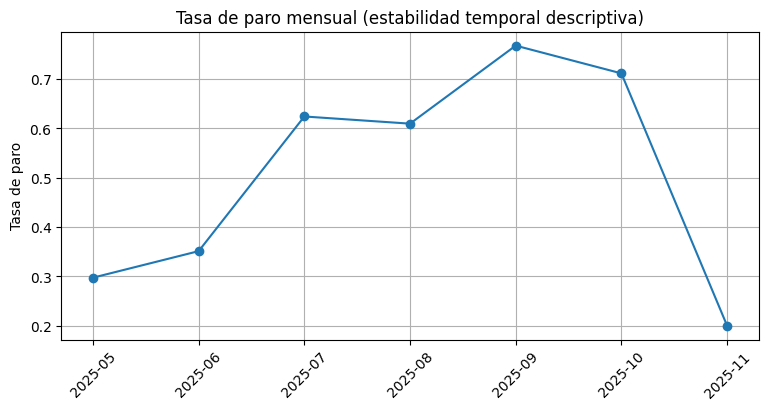

In [21]:
# Matriz Spearman solo con numéricas
# Definir X_cols como todas las columnas numéricas de df_eda
X_cols = df_eda.select_dtypes(include=np.number).columns.tolist()

num_for_corr = df_eda[X_cols].select_dtypes(include=np.number)

plt.figure(figsize=(10,6))
sns.heatmap(num_for_corr.corr(method='spearman'), cmap="coolwarm", center=0)
plt.title("Correlación Spearman (relaciones monotónicas no necesariamente lineales)")
plt.show()

df_trend = df_eda[['FECHA', target]].copy()
df_trend['MES'] = df_trend['FECHA'].dt.to_period('M').astype(str)

paro_mensual = df_trend.groupby('MES')[target].mean().reset_index().rename(columns={target:"TASA_PARO"})

plt.figure(figsize=(9,4))
plt.plot(paro_mensual['MES'], paro_mensual['TASA_PARO'], marker='o')
plt.xticks(rotation=45)
plt.title("Tasa de paro mensual (estabilidad temporal descriptiva)")
plt.ylabel("Tasa de paro")
plt.grid(True)
plt.show()

**Aplicación modelo random forest**


1. Preparación de datos para el modelo

In [22]:
import pandas as pd
import numpy as np

# Dataset sin fuga
df_model = df_eda.copy()

target = "PARO MAQUINA"
df_model[target] = df_model[target].astype(int)

# Features permitidas para anticipar
features = [
    "FECHA",      # solo para ordenar split
    "OF", "LINEA", "TURNO",
    "CODIGO", "PRODUCTO", "SUPERVISOR",
    "inicio_hora", "inicio_min",
    "dia_semana", "mes",
    "alm_mer_min"
]

df_model = df_model[features + [target]].copy()
df_model = df_model.sort_values("FECHA").reset_index(drop=True)

print("Dimensión df_model:", df_model.shape)
print("Rango FECHA:", df_model["FECHA"].min(), "->", df_model["FECHA"].max())

print("\n% nulos por columna:")
display((df_model.isna().mean()*100).round(2).to_frame("% nulos").sort_values("% nulos", ascending=False))
display(df_model.head())


Dimensión df_model: (1986, 13)
Rango FECHA: 2025-05-01 00:00:00 -> 2025-11-29 00:00:00

% nulos por columna:


,% nulos
FECHA,0.0
OF,0.0
LINEA,0.0
TURNO,0.0
CODIGO,0.0
PRODUCTO,0.0
SUPERVISOR,0.0
inicio_hora,0.0
inicio_min,0.0
dia_semana,0.0


,FECHA,OF,LINEA,TURNO,CODIGO,PRODUCTO,SUPERVISOR,inicio_hora,inicio_min,dia_semana,mes,alm_mer_min,PARO MAQUINA
0,2025-05-01,1204,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,ADRIAN LOPEZ,0,0,3,5,0.0,0
1,2025-05-01,1204,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,ADRIAN LOPEZ,0,5,3,5,0.0,1
2,2025-05-01,1204,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,ADRIAN LOPEZ,0,18,3,5,30.0,0
3,2025-05-01,1204,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,ADRIAN LOPEZ,2,28,3,5,0.0,1
4,2025-05-01,1204,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,ADRIAN LOPEZ,2,50,3,5,0.0,0


2. Se separan los datos para entrenamiento, validación y prueba


In [23]:
cut = int(len(df_model) * 0.8)

train_df = df_model.iloc[:cut].copy()
test_df  = df_model.iloc[cut:].copy()

print("Train:", train_df.shape, "| Test:", test_df.shape)
print("Train FECHA:", train_df["FECHA"].min(), "->", train_df["FECHA"].max())
print("Test  FECHA:", test_df["FECHA"].min(), "->", test_df["FECHA"].max())

X_train = train_df.drop(columns=["FECHA", target])
y_train = train_df[target]

X_test  = test_df.drop(columns=["FECHA", target])
y_test  = test_df[target]

print("\nDistribución Train (%):")
display((y_train.value_counts(normalize=True)*100).round(2).to_frame("%"))

print("\nDistribución Test (%):")
display((y_test.value_counts(normalize=True)*100).round(2).to_frame("%"))


Train: (1588, 13) | Test: (398, 13)
Train FECHA: 2025-05-01 00:00:00 -> 2025-10-15 00:00:00
Test  FECHA: 2025-10-15 00:00:00 -> 2025-11-29 00:00:00

Distribución Train (%):


,%
PARO MAQUINA,
1,62.41
0,37.59



Distribución Test (%):


,%
PARO MAQUINA,
1,50.75
0,49.25


3. Aplicación random forest sin hacer balanceo de datos

Numéricas: ['OF', 'LINEA', 'TURNO', 'inicio_hora', 'inicio_min', 'dia_semana', 'mes', 'alm_mer_min']
Categóricas: ['CODIGO', 'PRODUCTO', 'SUPERVISOR']

primera prueba: RF_noSMOTE_1_baseline
Params: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': 'balanced'}
ROC-AUC: 0.9738

Matriz de confusión (umbral=0.5):
[[167  29]
 [  3 199]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9824    0.8520    0.9126       196
           1     0.8728    0.9851    0.9256       202

    accuracy                         0.9196       398
   macro avg     0.9276    0.9186    0.9191       398
weighted avg     0.9268    0.9196    0.9192       398



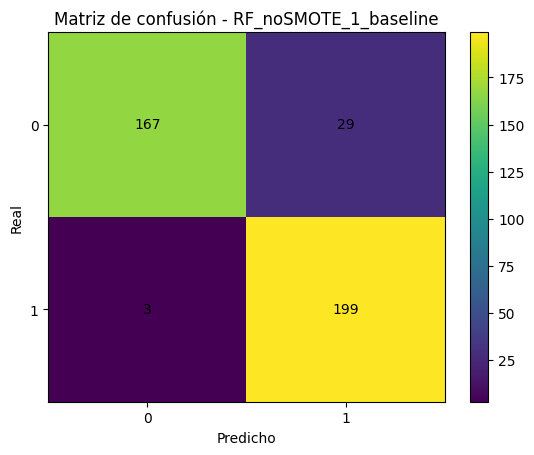


primera prueba: RF_noSMOTE_2_regularizado
Params: {'n_estimators': 500, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 5, 'class_weight': 'balanced'}
ROC-AUC: 0.9725

Matriz de confusión (umbral=0.5):
[[171  25]
 [  4 198]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9771    0.8724    0.9218       196
           1     0.8879    0.9802    0.9318       202

    accuracy                         0.9271       398
   macro avg     0.9325    0.9263    0.9268       398
weighted avg     0.9318    0.9271    0.9269       398



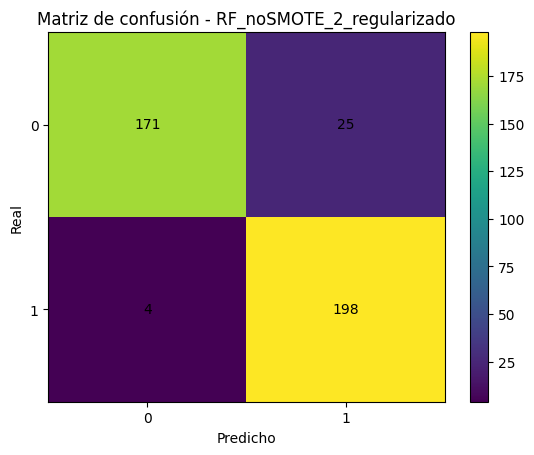


primera prueba: RF_noSMOTE_3_prof_moderada
Params: {'n_estimators': 800, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': 'balanced'}
ROC-AUC: 0.975

Matriz de confusión (umbral=0.5):
[[170  26]
 [  4 198]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9770    0.8673    0.9189       196
           1     0.8839    0.9802    0.9296       202

    accuracy                         0.9246       398
   macro avg     0.9305    0.9238    0.9242       398
weighted avg     0.9298    0.9246    0.9243       398



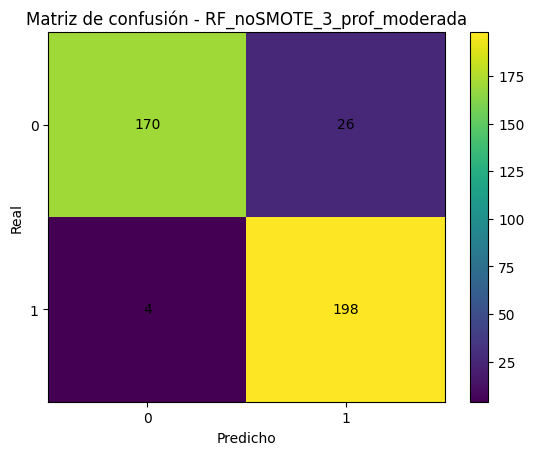


Resumen ROC-AUC (sin SMOTE):


,Experimento,ROC_AUC
2,RF_noSMOTE_3_prof_moderada,0.975045
0,RF_noSMOTE_1_baseline,0.973846
1,RF_noSMOTE_2_regularizado,0.972469


In [24]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import matplotlib.pyplot as plt

# Columnas categóricas y numéricas
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# Preprocesamiento: imputar + one-hot
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

def run_rf_no_smote(exp_name, rf_params, random_state=42):
    clf = RandomForestClassifier(
        **rf_params,
        random_state=random_state,
        n_jobs=-1
    )

    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", clf)
    ])

    pipe.fit(X_train, y_train)

    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    cm = confusion_matrix(y_test, pred)
    auc = roc_auc_score(y_test, proba)

    print("\n" + "="*70)
    print(f"primera prueba: {exp_name}")
    print("Params:", rf_params)
    print("ROC-AUC:", round(auc, 4))
    print("\nMatriz de confusión (umbral=0.5):")
    print(cm)
    print("\nReporte de clasificación:")
    print(classification_report(y_test, pred, digits=4))

    plt.figure()
    plt.imshow(cm, aspect="auto")
    plt.title(f"Matriz de confusión - {exp_name}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.colorbar()
    plt.xticks([0,1], ["0", "1"])
    plt.yticks([0,1], ["0", "1"])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()

    return {"exp": exp_name, "auc": auc, "cm": cm}

experiments_no = []

# 1) Baseline
experiments_no.append(run_rf_no_smote(
    "RF_noSMOTE_1_baseline",
    rf_params=dict(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced"  # ayuda algo si hay ligera asimetría
    )
))

# 2) Regularizado
experiments_no.append(run_rf_no_smote(
    "RF_noSMOTE_2_regularizado",
    rf_params=dict(
        n_estimators=500,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight="balanced"
    )
))

# 3) Profundidad moderada + más árboles
experiments_no.append(run_rf_no_smote(
    "RF_noSMOTE_3_prof_moderada",
    rf_params=dict(
        n_estimators=800,
        max_depth=18,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight="balanced"
    )
))

res_no = pd.DataFrame([{"Experimento": e["exp"], "ROC_AUC": e["auc"]} for e in experiments_no]).sort_values("ROC_AUC", ascending=False)
print("\nResumen ROC-AUC (sin SMOTE):")
display(res_no)


4. Aplicación random forest con balanceo de datos (SMOTE)


Experiment: RF_SMOTE_1_baseline
Params: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': None}
ROC-AUC: 0.9748

Matriz de confusión (umbral=0.5):
[[169  27]
 [  3 199]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9826    0.8622    0.9185       196
           1     0.8805    0.9851    0.9299       202

    accuracy                         0.9246       398
   macro avg     0.9315    0.9237    0.9242       398
weighted avg     0.9308    0.9246    0.9243       398



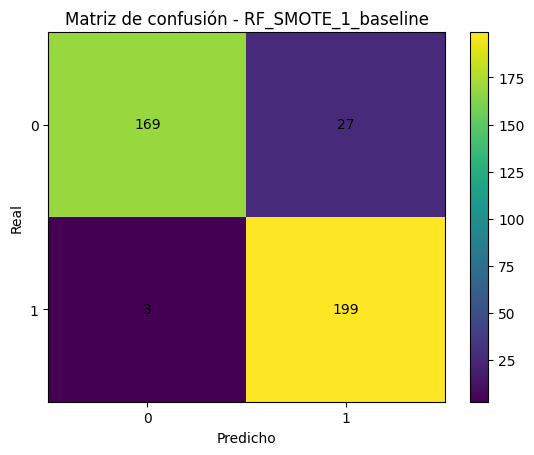


Experiment: RF_SMOTE_2_regularizado
Params: {'n_estimators': 500, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 5, 'class_weight': None}
ROC-AUC: 0.973

Matriz de confusión (umbral=0.5):
[[169  27]
 [  3 199]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9826    0.8622    0.9185       196
           1     0.8805    0.9851    0.9299       202

    accuracy                         0.9246       398
   macro avg     0.9315    0.9237    0.9242       398
weighted avg     0.9308    0.9246    0.9243       398



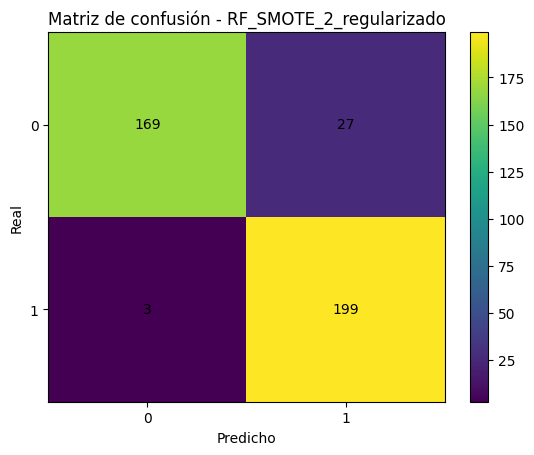


Experiment: RF_SMOTE_3_prof_moderada
Params: {'n_estimators': 800, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': None}
ROC-AUC: 0.9737

Matriz de confusión (umbral=0.5):
[[170  26]
 [  3 199]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9827    0.8673    0.9214       196
           1     0.8844    0.9851    0.9321       202

    accuracy                         0.9271       398
   macro avg     0.9336    0.9262    0.9267       398
weighted avg     0.9328    0.9271    0.9268       398



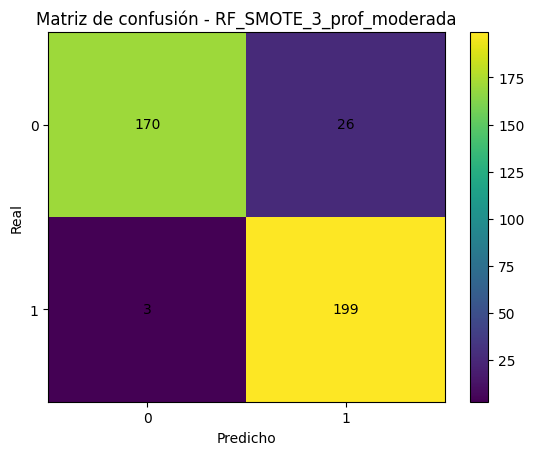


Resumen ROC-AUC (con SMOTE):


,Experimento,ROC_AUC
0,RF_SMOTE_1_baseline,0.974780
2,RF_SMOTE_3_prof_moderada,0.973732
1,RF_SMOTE_2_regularizado,0.973025


In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# La función `preprocess` ya está definida en la celda anterior (NkCi0RJ6JFDH).
# Solo la usaremos aquí, no es necesario redefinirla.

def run_rf_with_smote(exp_name, rf_params, random_state=42):
    # Re-definir el pipeline con SMOTE
    clf = RandomForestClassifier(
        **rf_params,
        random_state=random_state,
        n_jobs=-1
    )

    pipe_smote = ImbPipeline(steps=[
        ("preprocess", preprocess), # Usamos el preprocesamiento ya definido
        ("smote", SMOTE(random_state=random_state, sampling_strategy='auto')), # Aplicamos SMOTE
        ("model", clf)
    ])

    pipe_smote.fit(X_train, y_train)

    proba = pipe_smote.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    cm = confusion_matrix(y_test, pred)
    auc = roc_auc_score(y_test, proba)

    print("\n" + "="*70)
    print(f"Experiment: {exp_name}")
    print("Params:", rf_params)
    print("ROC-AUC:", round(auc, 4))
    print("\nMatriz de confusión (umbral=0.5):")
    print(cm)
    print("\nReporte de clasificación:")
    print(classification_report(y_test, pred, digits=4))

    plt.figure()
    plt.imshow(cm, aspect="auto")
    plt.title(f"Matriz de confusión - {exp_name}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.colorbar()
    plt.xticks([0,1], ["0", "1"])
    plt.yticks([0,1], ["0", "1"])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()

    return {"exp": exp_name, "auc": auc, "cm": cm}

experiments_smote = []

# 1) Baseline con SMOTE
experiments_smote.append(run_rf_with_smote(
    "RF_SMOTE_1_baseline",
    rf_params=dict(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight=None # SMOTE maneja el desbalance, no necesitamos class_weight aquí
    )
))

# 2) Regularizado con SMOTE
experiments_smote.append(run_rf_with_smote(
    "RF_SMOTE_2_regularizado",
    rf_params=dict(
        n_estimators=500,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight=None
    )
))

# 3) Profundidad moderada + más árboles con SMOTE
experiments_smote.append(run_rf_with_smote(
    "RF_SMOTE_3_prof_moderada",
    rf_params=dict(
        n_estimators=800,
        max_depth=18,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=None
    )
))

res_smote = pd.DataFrame([{"Experimento": e["exp"], "ROC_AUC": e["auc"]} for e in experiments_smote]).sort_values("ROC_AUC", ascending=False)
print("\nResumen ROC-AUC (con SMOTE):")
display(res_smote)

## Ajuste del Umbral de Predicción

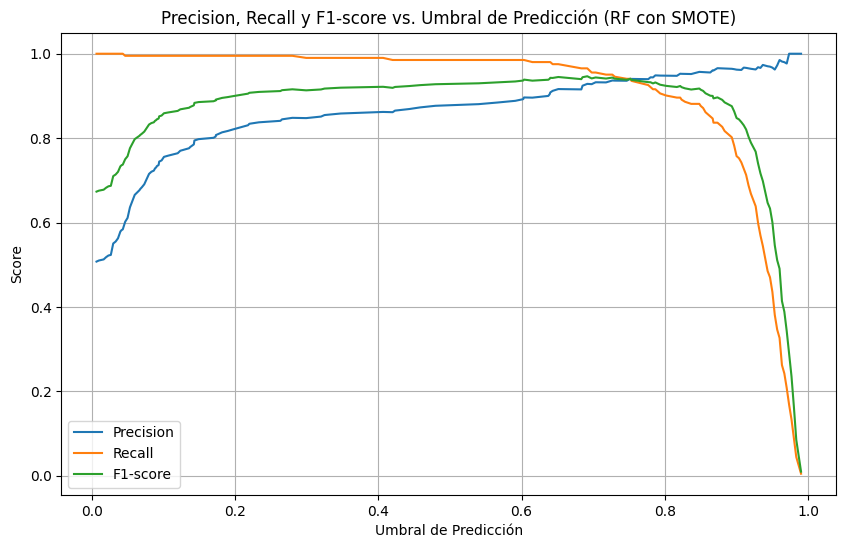


El umbral que maximiza el F1-score es: 0.6917

Matriz de Confusión con umbral óptimo:
[[181  15]
 [  7 195]]

Reporte de Clasificación con umbral óptimo:
              precision    recall  f1-score   support

           0     0.9628    0.9235    0.9427       196
           1     0.9286    0.9653    0.9466       202

    accuracy                         0.9447       398
   macro avg     0.9457    0.9444    0.9447       398
weighted avg     0.9454    0.9447    0.9447       398



In [26]:
from sklearn.metrics import precision_recall_curve, f1_score

# Volver a entrenar el mejor modelo con SMOTE para obtener el pipeline y las probabilidades
# Para evitar re-escribir el código, tomamos la lógica del mejor experimento de SMOTE
# (RF_SMOTE_1_baseline) y extraemos la probabilidad.

# Parámetros del mejor modelo SMOTE
best_smote_rf_params = dict(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight=None
)

# Redefinir el pipeline para obtener el objeto entrenado
clf_best_smote = RandomForestClassifier(
    **best_smote_rf_params,
    random_state=42,
    n_jobs=-1
)

pipe_best_smote = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42, sampling_strategy='auto')),
    ("model", clf_best_smote)
])

pipe_best_smote.fit(X_train, y_train)

# Obtener probabilidades para el conjunto de prueba
proba_best_smote = pipe_best_smote.predict_proba(X_test)[:, 1]

# Calcular precision, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, proba_best_smote)

# Calcular F1-score para cada umbral
f1_scores = [f1_score(y_test, (proba_best_smote >= t).astype(int)) for t in thresholds]

# Graficar Precision, Recall y F1-score en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score') # Corrección aquí: eliminamos [:-1]
plt.xlabel('Umbral de Predicción')
plt.ylabel('Score')
plt.title('Precision, Recall y F1-score vs. Umbral de Predicción (RF con SMOTE)')
plt.legend()
plt.grid(True)
plt.show()

# Encontrar el umbral que maximiza el F1-score
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]

print(f"\nEl umbral que maximiza el F1-score es: {optimal_threshold:.4f}")

# Evaluar el modelo con el umbral óptimo
optimal_pred = (proba_best_smote >= optimal_threshold).astype(int)
optimal_cm = confusion_matrix(y_test, optimal_pred)
optimal_auc = roc_auc_score(y_test, proba_best_smote)

print("\nMatriz de Confusión con umbral óptimo:")
print(optimal_cm)
print("\nReporte de Clasificación con umbral óptimo:")
print(classification_report(y_test, optimal_pred, digits=4))

## Comparación de Métricas: Umbral por Defecto vs. Umbral Óptimo

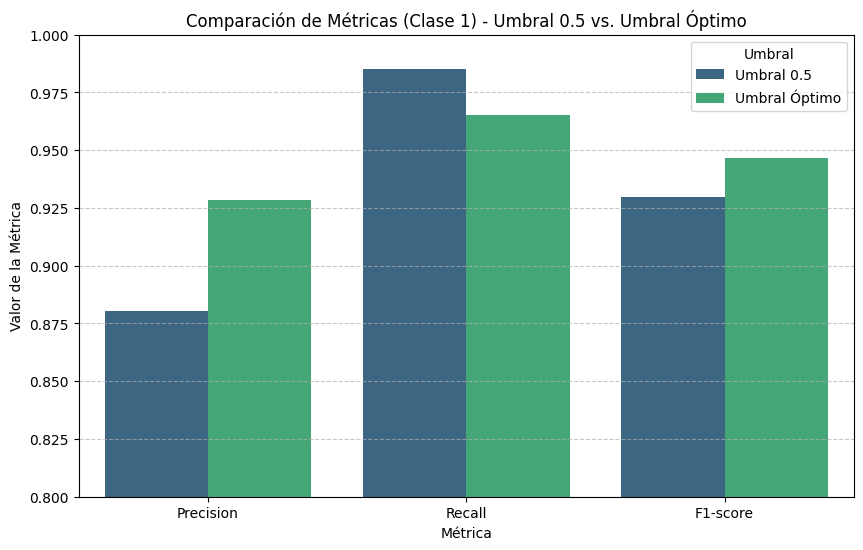


Comparación detallada de métricas (Clase 1):


,Métrica,Umbral 0.5,Umbral Óptimo
0,Precision,0.8805,0.9286
1,Recall,0.9851,0.9653
2,F1-score,0.9299,0.9466


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Métricas del mejor modelo SMOTE con umbral por defecto (0.5)
default_threshold_metrics = {
    'Precision': 0.8805, # para la clase 1
    'Recall': 0.9851,    # para la clase 1
    'F1-score': 0.9299   # para la clase 1
}

# Métricas del modelo con umbral óptimo (0.6917)
optimal_threshold_metrics = {
    'Precision': 0.9286, # para la clase 1
    'Recall': 0.9653,    # para la clase 1
    'F1-score': 0.9466   # para la clase 1
}

# Crear un DataFrame para la visualización
metrics_df = pd.DataFrame({
    'Métrica': list(default_threshold_metrics.keys()),
    'Umbral 0.5': list(default_threshold_metrics.values()),
    'Umbral Óptimo': list(optimal_threshold_metrics.values())
})

metrics_df_melted = metrics_df.melt(id_vars='Métrica', var_name='Umbral', value_name='Valor')

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='Métrica', y='Valor', hue='Umbral', data=metrics_df_melted, palette='viridis')
plt.title('Comparación de Métricas (Clase 1) - Umbral 0.5 vs. Umbral Óptimo')
plt.ylabel('Valor de la Métrica')
plt.ylim(0.8, 1.0) # Ajustar el límite y para mejor visualización de las diferencias
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nComparación detallada de métricas (Clase 1):")
display(metrics_df)


## Análisis de Importancia de Variables


Top 15 Características más Importantes:


,Feature,Importance
4,inicio_min,0.427792
7,alm_mer_min,0.233715
3,inicio_hora,0.102836
0,OF,0.053163
2,TURNO,0.041081
1,LINEA,0.025562
6,mes,0.023204
5,dia_semana,0.022626
36,SUPERVISOR_MARCIAL VERA,0.008633
12,CODIGO_PTX2BCOPO015,0.007583


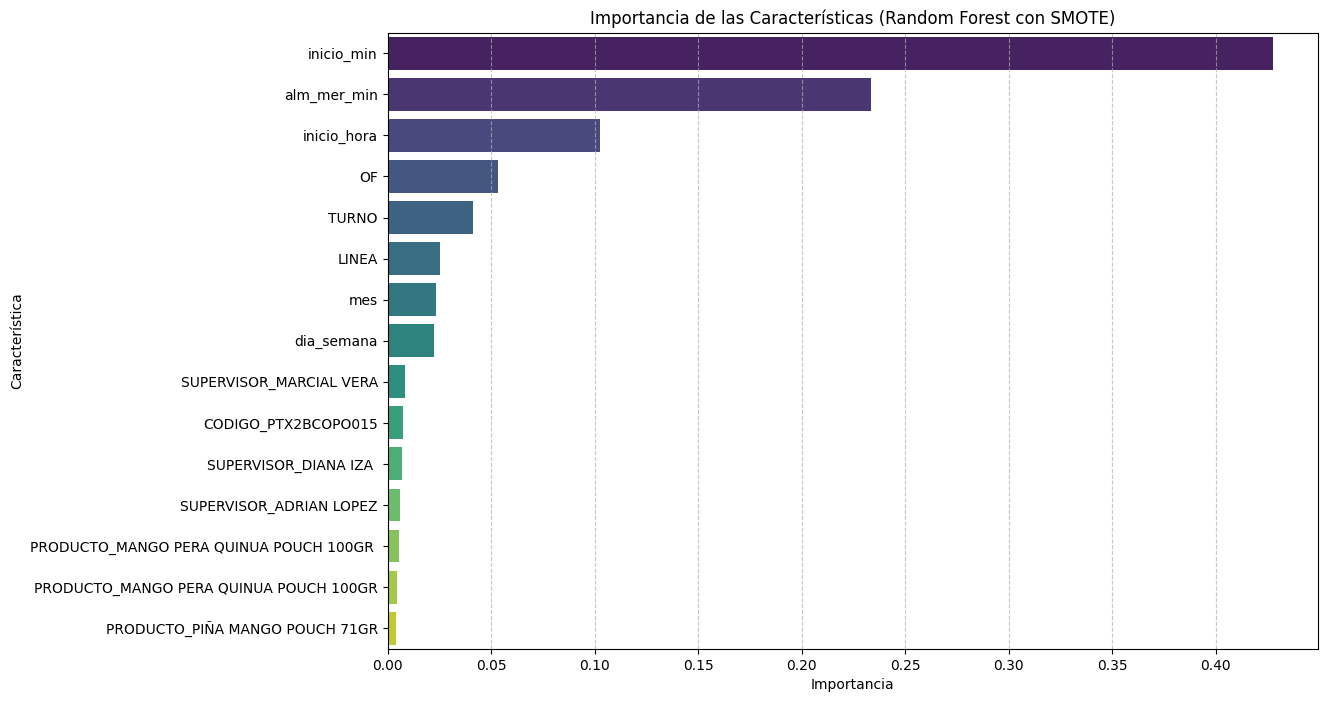

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # Import joblib for loading the model
import pandas as pd # Needed for DataFrame
import numpy as np # Needed for np.concatenate

# Define model filename (assuming it's the same as where it was saved)
model_filename = '/content/drive/MyDrive/Tesis Maestria UDLA/modelo_final_rf_smote.joblib'

# Load the pipeline to ensure pipe_best_smote is defined
pipe_best_smote = joblib.load(model_filename)

# Re-define num_cols and cat_cols as they are needed by get_feature_names_out
# These lists are static and come from the earlier definition in cell NkCi0RJ6JFDH
num_cols = ['OF', 'LINEA', 'TURNO', 'inicio_hora', 'inicio_min', 'dia_semana', 'mes', 'alm_mer_min']
cat_cols = ['CODIGO', 'PRODUCTO', 'SUPERVISOR']

# Acceder al modelo entrenado desde el pipeline
model = pipe_best_smote.named_steps['model']

# Acceder al preprocesador
preprocessor = pipe_best_smote.named_steps['preprocess']

# Obtener los nombres de las características después del preprocesamiento
# Nombres de características numéricas
num_features = preprocessor.named_transformers_['num'].get_feature_names_out(num_cols)

# Nombres de características categóricas después de one-hot encoding
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

# Combinar todos los nombres de las características
feature_names = np.concatenate([num_features, cat_features])

# Obtener las importancias de las características
importances = model.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar por importancia y mostrar las top N
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 15 Características más Importantes:")
display(feature_importance_df.head(15))

# Graficar las top N características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df.head(15), palette='viridis', legend=False)
plt.title('Importancia de las Características (Random Forest con SMOTE)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Guardar el Modelo Final

In [29]:
import joblib

# Definir el nombre del archivo para guardar el modelo
modelfinal_filename = '/content/drive/MyDrive/Tesis Maestria UDLA/modelo_final_rf_smote.joblib'

# Guardar el pipeline completo (incluyendo preprocesamiento, SMOTE y el clasificador)
joblib.dump(pipe_best_smote, modelfinal_filename)

print(f"El modelo final ha sido guardado en: {modelfinal_filename}")

# También guardamos el umbral óptimo
umbral_filename = '/content/drive/MyDrive/Tesis Maestria UDLA/umbral_optimo.txt'
with open(umbral_filename, 'w') as f:
    f.write(str(optimal_threshold))

print(f"El umbral óptimo ha sido guardado en: {umbral_filename}")

El modelo final ha sido guardado en: /content/drive/MyDrive/Tesis Maestria UDLA/modelo_final_rf_smote.joblib
El umbral óptimo ha sido guardado en: /content/drive/MyDrive/Tesis Maestria UDLA/umbral_optimo.txt


### Cómo usar el Modelo y Umbral Guardados para hacer Predicciones

In [30]:
import joblib
import pandas as pd
import numpy as np

# --- 1. Definir rutas de los archivos guardados ---
model_filename = '/content/drive/MyDrive/Tesis Maestria UDLA/modelo_final_rf_smote.joblib'
umbral_filename = '/content/drive/MyDrive/Tesis Maestria UDLA/umbral_optimo.txt'

# --- 2. Cargar el Modelo ---
print(f"Cargando el modelo desde: {model_filename}")
loaded_pipeline = joblib.load(model_filename)
print("Modelo cargado exitosamente.")

# --- 3. Cargar el Umbral Óptimo ---
print(f"Cargando el umbral óptimo desde: {umbral_filename}")
with open(umbral_filename, 'r') as f:
    loaded_optimal_threshold = float(f.read())
print(f"Umbral óptimo cargado: {loaded_optimal_threshold:.4f}")

# --- 4. Preparar Nuevos Datos para Predicción (Ejemplo) ---
# Para demostrar, usaremos una parte del X_test original como si fueran "nuevos datos"
# En un escenario real, X_new sería un nuevo DataFrame con las mismas columnas de características
# (excluyendo FECHA y PARO MAQUINA) que X_train.

X_new = X_test.head(10).copy() # Tomamos las primeras 10 filas de X_test como ejemplo

print("\nEjemplo de nuevos datos a predecir (primeras 5 filas):")
display(X_new.head())

# --- 5. Realizar Predicciones con el Umbral Óptimo ---
# Obtener las probabilidades de la clase positiva (PARO MAQUINA = 1)
probabilities_new = loaded_pipeline.predict_proba(X_new)[:, 1]

# Aplicar el umbral óptimo para obtener las predicciones binarias
predictions_new = (probabilities_new >= loaded_optimal_threshold).astype(int)

print("\nProbabilidades de Paro de Máquina para los nuevos datos:")
print(probabilities_new.round(4))

print("\nPredicciones (0 = No Paro, 1 = Paro) usando el umbral óptimo:")
print(predictions_new)


Cargando el modelo desde: /content/drive/MyDrive/Tesis Maestria UDLA/modelo_final_rf_smote.joblib
Modelo cargado exitosamente.
Cargando el umbral óptimo desde: /content/drive/MyDrive/Tesis Maestria UDLA/umbral_optimo.txt
Umbral óptimo cargado: 0.6917

Ejemplo de nuevos datos a predecir (primeras 5 filas):


,OF,LINEA,TURNO,CODIGO,PRODUCTO,SUPERVISOR,inicio_hora,inicio_min,dia_semana,mes,alm_mer_min
1588,1982,7,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,MARCIAL VERA,16,50,2,10,0.0
1589,1982,6,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,MARCIAL VERA,15,30,2,10,0.0
1590,1982,7,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,MARCIAL VERA,19,0,2,10,0.0
1591,1998,7,2,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,ADRIAN LOPEZ,8,40,3,10,30.0
1592,1998,7,1,PTX2BCOPO015,MANGO PERA QUINUA POUCH 100GR,ADRIAN LOPEZ,17,10,3,10,0.0



Probabilidades de Paro de Máquina para los nuevos datos:
[0.8167 0.8367 0.0667 0.2333 0.96   0.96   0.95   0.96   0.9367 0.9467]

Predicciones (0 = No Paro, 1 = Paro) usando el umbral óptimo:
[1 1 0 0 1 1 1 1 1 1]
